In [37]:
import polars as pl
import numpy as np
from datetime import datetime,timedelta
import random

# Pytorch for ML

import torch
import torch.nn as nn
import torch.optim as optim
import research

#visualization
import altair as alt

#data
import binance

import importlib
importlib.reload(research)
importlib.reload(binance)

<module 'binance' from '/Users/ujjawalpratapsingh/Documents/quant-strategy/binance.py'>

In [2]:
research.set_seed(42)

In [3]:
pl.Config.set_tbl_width_chars(200)
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(-1)

polars.config.Config

In [4]:
sym = 'BTCUSDT'

hist_data_window = 7 * 4 * 6

time_interval = '1h'

max_lags = 4

forecast_horizon = 1

annualized_rate = research.sharpe_annualization_factor(time_interval, 365,24)

In [5]:
binance.download_trades(sym,hist_data_window)

downloading BTCUSDT: 100%|██████████| 168/168 [00:02<00:00, 58.00it/s]

[ERROR] BTCUSDT 2025-10-23: HTTPSConnectionPool(host='data.binance.vision', port=443): Max retries exceeded with url: /data/futures/um/daily/trades/BTCUSDT/BTCUSDT-trades-2025-10-23.zip (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x11fd1bf10>: Failed to resolve 'data.binance.vision' ([Errno 8] nodename nor servname provided, or not known)"))
[ERROR] BTCUSDT 2025-10-24: HTTPSConnectionPool(host='data.binance.vision', port=443): Max retries exceeded with url: /data/futures/um/daily/trades/BTCUSDT/BTCUSDT-trades-2025-10-24.zip (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x118d67610>: Failed to resolve 'data.binance.vision' ([Errno 8] nodename nor servname provided, or not known)"))
[ERROR] BTCUSDT 2025-10-25: HTTPSConnectionPool(host='data.binance.vision', port=443): Max retries exceeded with url: /data/futures/um/daily/trades/BTCUSDT/BTCUSDT-trades-2025-10-25.zip (Caused by NameResolutionError("<urllib3.connection.HTTPSC

In [6]:
ts = research.load_ohlc_timeseries(sym,time_interval)
ts

Loading BTCUSDT: 100%|██████████| 393/393 [00:23<00:00, 16.80file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-09-25 00:00:00,64243.2,64410.0,63955.9,64090.1
2024-09-25 01:00:00,64090.2,64800.0,64051.7,64355.0
2024-09-25 02:00:00,64355.1,64533.0,64253.4,64390.0
2024-09-25 03:00:00,64390.0,64433.3,64191.8,64422.4
2024-09-25 04:00:00,64422.5,64430.0,64140.0,64142.3
…,…,…,…,…
2025-10-22 19:00:00,107987.7,108379.3,107491.8,107829.0
2025-10-22 20:00:00,107829.1,108032.0,107453.9,107644.4
2025-10-22 21:00:00,107644.4,107694.6,106588.0,107159.8


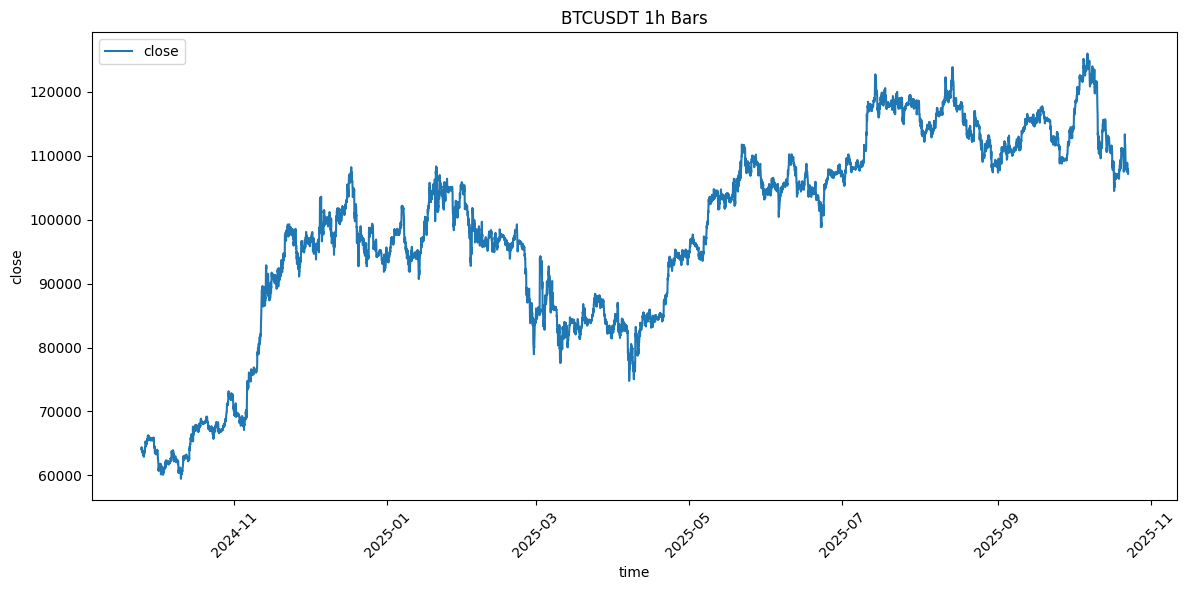

In [7]:
research.plot_static_timeseries(ts,sym,'close',time_interval)

In [8]:
alt.data_transformers.enable("vegafusion")
research.plot_dyn_timeseries(ts, sym,'close',time_interval)

alt.Chart(...)

In [9]:
ts = ts.with_columns((pl.col('close')/pl.col('close').shift(forecast_horizon)).log().alias('close_log_return'))

In [10]:
target = 'close_log_return'
ts = research.add_lags(ts, target, max_lags,forecast_horizon)

In [11]:
ts = ts.drop_nulls()

In [12]:
research.plot_distribution(ts, target, no_bins = 200)

alt.Chart(...)

In [13]:
research.plot_distribution(ts, 'close', no_bins = 200)

alt.Chart(...)

In [14]:
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel,self).__init__()
        self.linear = nn.Linear(input_features,1)

    def forward(self,x):
        return self.linear(x)

In [15]:
input_features = 1

linear_model = LinearModel(input_features)

In [16]:
features = ['close_log_return_lag_1']
target = 'close_log_return'
test_size = 0.25

In [17]:
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-09-25 05:00:00,64142.2,64254.1,64108.4,64140.0,-0.000036,-0.004357,0.000503,0.000544,0.004125
2024-09-25 06:00:00,64140.0,64140.0,63713.3,63776.6,-0.005682,-0.000036,-0.004357,0.000503,0.000544
2024-09-25 07:00:00,63776.5,63838.1,63612.3,63814.9,0.0006,-0.005682,-0.000036,-0.004357,0.000503
2024-09-25 08:00:00,63814.9,63888.3,63726.4,63795.2,-0.000309,0.0006,-0.005682,-0.000036,-0.004357
2024-09-25 09:00:00,63795.2,63844.0,63579.0,63588.0,-0.003253,-0.000309,0.0006,-0.005682,-0.000036
…,…,…,…,…,…,…,…,…,…
2025-10-22 19:00:00,107987.7,108379.3,107491.8,107829.0,-0.001472,0.002266,-0.00402,-0.001778,-0.004996
2025-10-22 20:00:00,107829.1,108032.0,107453.9,107644.4,-0.001713,-0.001472,0.002266,-0.00402,-0.001778
2025-10-22 21:00:00,107644.4,107694.6,106588.0,107159.8,-0.004512,-0.001713,-0.001472,0.002266,-0.00402


In [18]:
X_train,X_test,y_train,y_test = research.timeseries_train_test_split(ts,features,target,test_size)

In [19]:
no_epochs = 1000 * 5
lr = 0.0005

model = LinearModel(len(features))

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr = lr)

print("\n Training Model .....")

for epoch in range(no_epochs):
    y_hat = model(X_train)
    loss = criterion(y_hat,y_train)

    #backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss = loss.item()

    if (epoch+1) % 500 == 0:
        print(f"Epoch [{epoch+1/no_epochs}], Loss: {train_loss: .6f}")

print("\n Learned Parameters")

for name,param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: \n{param.data.numpy()}")

model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_loss = criterion(y_hat,y_test)
    print(f"\n Test Loss : {test_loss.item():.6f}, Train Loss : {train_loss:.6f}")


 Training Model .....
Epoch [499.0002], Loss:  0.468812
Epoch [999.0002], Loss:  0.234587
Epoch [1499.0002], Loss:  0.101724
Epoch [1999.0002], Loss:  0.036152
Epoch [2499.0002], Loss:  0.009765
Epoch [2999.0002], Loss:  0.001831
Epoch [3499.0002], Loss:  0.000231
Epoch [3999.0002], Loss:  0.000040
Epoch [4499.0002], Loss:  0.000028
Epoch [4999.0002], Loss:  0.000027

 Learned Parameters
linear.weight: 
[[-0.08441021]]
linear.bias: 
[0.00014488]

 Test Loss : 0.000013, Train Loss : 0.000027


### Test Trading performance

In [20]:
trade_results = pl.DataFrame({
    'y_hat': y_hat.squeeze(),
    'y' :y_test.squeeze()
}).with_columns(
    (pl.col('y_hat').sign() == pl.col('y').sign()).alias('is_win'),
    pl.col('y_hat').sign().alias('signal')
).with_columns(
    (pl.col('signal') * pl.col('y')).alias('trade_log_return')
).with_columns(
    pl.col('trade_log_return').cum_sum().alias('equity_curve')
)

In [21]:
trade_results

y_hat,y,is_win,signal,trade_log_return,equity_curve
f32,f32,bool,f32,f32,f32
-0.000161,-0.002382,true,-1.0,0.002382,0.002382
0.000346,0.005852,true,1.0,0.005852,0.008234
-0.000349,-0.005281,true,-1.0,0.005281,0.013516
0.000591,-0.005296,false,1.0,-0.005296,0.00822
0.000592,-0.000288,false,1.0,-0.000288,0.007932
…,…,…,…,…,…
-0.000046,-0.001472,true,-1.0,0.001472,-0.033474
0.000269,-0.001713,false,1.0,-0.001713,-0.035187
0.00029,-0.004512,false,1.0,-0.004512,-0.039699


In [22]:
research.plot_column(trade_results,'equity_curve')

alt.Chart(...)

In [23]:
trade_results = trade_results.with_columns(
    (pl.col('equity_curve') - pl.col('equity_curve').cum_max()).alias('drawdown_log')
)
trade_results

y_hat,y,is_win,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
-0.000161,-0.002382,true,-1.0,0.002382,0.002382,0.0
0.000346,0.005852,true,1.0,0.005852,0.008234,0.0
-0.000349,-0.005281,true,-1.0,0.005281,0.013516,0.0
0.000591,-0.005296,false,1.0,-0.005296,0.00822,-0.005296
0.000592,-0.000288,false,1.0,-0.000288,0.007932,-0.005583
…,…,…,…,…,…,…
-0.000046,-0.001472,true,-1.0,0.001472,-0.033474,-0.228434
0.000269,-0.001713,false,1.0,-0.001713,-0.035187,-0.230148
0.00029,-0.004512,false,1.0,-0.004512,-0.039699,-0.23466


In [24]:
max_drawdown_log = trade_results['drawdown_log'].min()
max_drawdown_log

-0.2717815339565277

In [25]:
drawdown_pct = np.exp(max_drawdown_log) - 1
drawdown_pct

np.float64(-0.2379792814420495)

In [26]:
equity_peak = 1000
equity_peak * drawdown_pct

np.float64(-237.97928144204948)

In [27]:
win_rate = trade_results['is_win'].mean()
win_rate

0.4972422571064913

In [28]:
avg_win = trade_results.filter(pl.col('is_win') == True)['trade_log_return'].mean()
avg_loss = trade_results.filter(pl.col('is_win') == False)['trade_log_return'].mean()

In [29]:
ev = win_rate * avg_win + (1- win_rate) * avg_loss
ev

-1.537213113569783e-05

In [30]:
total_log_return = trade_results["trade_log_return"].sum()
total_log_return

-0.036232128739356995

In [31]:
compound_return = np.exp(total_log_return)
compound_return

np.float64(0.964416398735072)

In [32]:
equity_trough = trade_results["equity_curve"].min()
equity_trough

-0.07682110369205475

In [33]:
equity_peak = trade_results["equity_curve"].max()
equity_peak

0.19496043026447296

In [34]:
std = trade_results["equity_curve"].std()
std

0.061337053775787354

In [35]:
sharpe = ev/std * annualized_rate
sharpe


np.float64(-0.023456500632703884)

In [38]:
research.eval_model_performance(y_test,y_hat,features,target,annualized_rate)

{'features': 'close_log_return_lag_1',
 'target': 'close_log_return',
 'num_trades': 2357,
 'win_rate': 0.4972422571064913,
 'avg_loss': -0.0024383449585320895,
 'avg_win': 0.0024344766747215756,
 'best_trade': 0.03395244851708412,
 'worst_trade': -0.02237566001713276,
 'ev': -1.537213113569783e-05,
 'std': 0.061337053775787354,
 'total_log_return': -0.036232128739356995,
 'compound_return': np.float64(0.964416398735072),
 'max_drawdown': -0.2717815339565277,
 'equity_trough': -0.07682110369205475,
 'equity_peak': 0.19496043026447296,
 'sharpe': np.float64(-0.3993786365327251)}